# Collaboration and Competition

---

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='../apps/Tennis.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
import copy
from collections import deque, namedtuple

In [5]:
# Helper Functions
def random_sample(indices, batch_size):
    indices = np.asarray(np.random.permutation(indices))
    batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)
    for batch in batches:
        yield batch
    r = len(indices) % batch_size
    if r:
        yield indices[-r:]

def layer_init(layer, w_scale=1.0):
    nn.init.orthogonal_(layer.weight.data)
    layer.weight.data.mul_(w_scale)
    nn.init.constant_(layer.bias.data, 0)
    return layer

def stack_tensor(some_list):
    return torch.cat(some_list[:1000], dim=0)

In [6]:
# Models
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Critic(nn.Module):
    def __init__(self, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(48, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 2)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, states):
        states = states.reshape(-1, 48)
        x = F.tanh(self.fc1(states))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Actor(nn.Module):
    def __init__(self, seed):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(24, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 2)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, states):
        x = F.tanh(self.fc1(states))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x  
    
class ActorAndCritic(nn.Module):
    def __init__(self, seed):
        super(ActorAndCritic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.sd = nn.Parameter(torch.zeros(2))
        self.actor = Actor(1)
        self.critic = Critic(1)
        
    def forward(self, states):
        x = self.actor(states)
        mean = F.tanh(x)
        values = self.critic(states).unsqueeze(2)
        dist = torch.distributions.Normal(mean, F.softplus(self.sd))
        actions = torch.clamp(dist.sample(), -1, 1)
        return actions, values, dist.log_prob(actions).mean(2).unsqueeze(2), dist

In [7]:
class Agent(nn.Module):
    def __init__(self):
        super(Agent, self).__init__()
        self.network = ActorAndCritic(5)
        self.optimizer = optim.Adam(self.network.parameters(), lr = 5e-5)
    
    def act(self, states):
        with torch.no_grad():
            actions, values, log_probs, dist = self.network(states)
        return actions, values, log_probs, dist
    
    def step(self, old_log_probs, states, actions, rewards, dones, values, mean_score):
        rewards = torch.tensor(rewards, dtype = torch.float).unsqueeze(2)
        dones = torch.tensor(dones, dtype = torch.int).unsqueeze(2)
        
        advantages = [0.0] * 250
        returns = [0.0] * 250
        advantage = torch.zeros((2, 1))
        return_ = torch.zeros((2, 1))
        for i in reversed(range(250)):
            if i == 250 - 1:
                td = (rewards[i] - values[i]).squeeze(0)
            else:
                td = (rewards[i] + (0.99 * (1-dones[i]) * values[i + 1]) - values[i]).squeeze(0)
            advantage = advantage * 0.95 * 0.99 * (1-dones[i]) + td
            return_ = rewards[i] + 0.99 * (1-dones[i]) * return_           
            advantages[i] = advantage
            returns[i] = return_
            
        old_log_probs, states, actions, values, advantages, returns = \
        torch.stack(old_log_probs), torch.stack(states), torch.stack(actions), \
        torch.stack(values), torch.stack(advantages), torch.stack(returns)
        advantages = torch.clamp((advantages - advantages.mean()) / advantages.std(), -1e5, 1e5)
        
        if mean_score>=0.80:
            epoch = 1
        elif mean_score>=0.40:
            epoch = 3
        elif mean_score>=0.20:
            epoch = 5
        else:
            epoch = 10
        for e in range(epoch):
            samples = random_sample(np.arange(250), 50)
            for sample in samples:
                states_1 = states[sample]
                actions_1 = actions[sample]
                old_log_probs_1 = old_log_probs[sample]
                advantages_1 = advantages[sample]
                returns_1 = returns[sample]
                
                _, values_1, _, dist = self.network(states_1)
                new_log_probs_1 = dist.log_prob(actions_1).mean(2).unsqueeze(2)

                new_probs, old_probs = torch.exp(new_log_probs_1), torch.exp(old_log_probs_1)
                ratios = new_probs / old_probs
                ratios_clipped = torch.clamp(ratios, 0.9, 1.1)
                entropy = -(new_probs * torch.log(old_probs + 1e-10) + (1.0 - new_probs) * torch.log(1.0 - old_probs + 1e-10))
                
                rewards_clipped = -torch.min(ratios * advantages_1, ratios_clipped * advantages_1)
                rewards_clipped = torch.mean(rewards_clipped + 0.01 * entropy)
                loss = 0.5 * torch.mean((returns_1 - values_1)**2)
                total_loss = rewards_clipped + loss
                
                self.optimizer.zero_grad()
                total_loss.backward()
                nn.utils.clip_grad_norm_(self.network.parameters(), 10) 
                self.optimizer.step()

agent = Agent()

In [8]:
scores = []
scores_window = deque(maxlen = 100)
scores_window_3 = deque(maxlen = 3)
log_probs_all, states_all, actions_all, rewards_all, dones_all, values_all = [], [], [], [], [], []
sample_num = 0
for i in range(15000): 
    env_info = env.reset(train_mode=True)[brain_name]     
    states = torch.tensor(env_info.vector_observations, dtype = torch.float).unsqueeze(0)
    score = np.zeros(num_agents) 
    while True:
        actions, values, log_probs, _ = agent.act(states)
        env_info = env.step(actions.squeeze(0).detach().numpy())[brain_name]           
        next_states = torch.tensor(env_info.vector_observations, dtype = torch.float).unsqueeze(0)
        dones = env_info.local_done
        
        log_probs_all.append(log_probs.squeeze(0))
        states_all.append(states.squeeze(0))
        actions_all.append(actions.squeeze(0))
        rewards_all.append(env_info.rewards)
        dones_all.append(dones)
        values_all.append(values)
        score += env_info.rewards
        states = next_states 
        
        if sample_num == 249 and np.mean(scores_window_3)<0.5:
            agent.step(log_probs_all, states_all, actions_all, rewards_all, dones_all, values_all, np.mean(scores_window))
            log_probs_all, states_all, actions_all, rewards_all, dones_all, values_all = [], [], [], [], [], []
        
        sample_num = (sample_num + 1) % 250
        if np.any(dones):
            break
    
    scores.append(np.max(score))
    scores_window.append(np.max(score))
    scores_window_3.append(np.max(score))
    print('\rEpisode {}\tReward: {:.5f}\tAverage Reward: {:.5f}'.format(i, np.max(score), np.mean(scores_window)))
    if np.mean(scores_window) >= 0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i-100, np.mean(scores_window)))
        torch.save(agent.network.state_dict(), 'checkpoint/trained_weights_ppo_v2.pth')
        break

/anaconda3/envs/reacher_ddpg/lib/python3.6/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 0	Reward: 0.00000	Average Reward: 0.00000
Episode 1	Reward: 0.09000	Average Reward: 0.04500
Episode 2	Reward: 0.00000	Average Reward: 0.03000
Episode 3	Reward: 0.00000	Average Reward: 0.02250
Episode 4	Reward: 0.09000	Average Reward: 0.03600
Episode 5	Reward: 0.00000	Average Reward: 0.03000
Episode 6	Reward: 0.00000	Average Reward: 0.02571
Episode 7	Reward: 0.10000	Average Reward: 0.03500
Episode 8	Reward: 0.00000	Average Reward: 0.03111
Episode 9	Reward: 0.00000	Average Reward: 0.02800
Episode 10	Reward: 0.00000	Average Reward: 0.02545
Episode 11	Reward: 0.00000	Average Reward: 0.02333
Episode 12	Reward: 0.00000	Average Reward: 0.02154
Episode 13	Reward: 0.10000	Average Reward: 0.02714
Episode 14	Reward: 0.00000	Average Reward: 0.02533
Episode 15	Reward: 0.00000	Average Reward: 0.02375
Episode 16	Reward: 0.10000	Average Reward: 0.02824
Episode 17	Reward: 0.00000	Average Reward: 0.02667
Episode 18	Reward: 0.00000	Average Reward: 0.02526
Episode 19	Reward: 0.00000	Average Reward

Episode 161	Reward: 0.09000	Average Reward: 0.01630
Episode 162	Reward: 0.00000	Average Reward: 0.01630
Episode 163	Reward: 0.10000	Average Reward: 0.01730
Episode 164	Reward: 0.00000	Average Reward: 0.01730
Episode 165	Reward: 0.00000	Average Reward: 0.01640
Episode 166	Reward: 0.00000	Average Reward: 0.01640
Episode 167	Reward: 0.00000	Average Reward: 0.01640
Episode 168	Reward: 0.00000	Average Reward: 0.01640
Episode 169	Reward: 0.00000	Average Reward: 0.01640
Episode 170	Reward: 0.00000	Average Reward: 0.01640
Episode 171	Reward: 0.00000	Average Reward: 0.01640
Episode 172	Reward: 0.00000	Average Reward: 0.01640
Episode 173	Reward: 0.00000	Average Reward: 0.01540
Episode 174	Reward: 0.00000	Average Reward: 0.01540
Episode 175	Reward: 0.00000	Average Reward: 0.01540
Episode 176	Reward: 0.00000	Average Reward: 0.01540
Episode 177	Reward: 0.00000	Average Reward: 0.01540
Episode 178	Reward: 0.00000	Average Reward: 0.01540
Episode 179	Reward: 0.00000	Average Reward: 0.01540
Episode 180	

Episode 319	Reward: 0.00000	Average Reward: 0.02530
Episode 320	Reward: 0.00000	Average Reward: 0.02440
Episode 321	Reward: 0.09000	Average Reward: 0.02530
Episode 322	Reward: 0.00000	Average Reward: 0.02430
Episode 323	Reward: 0.00000	Average Reward: 0.02330
Episode 324	Reward: 0.00000	Average Reward: 0.02330
Episode 325	Reward: 0.00000	Average Reward: 0.02330
Episode 326	Reward: 0.00000	Average Reward: 0.02330
Episode 327	Reward: 0.10000	Average Reward: 0.02430
Episode 328	Reward: 0.00000	Average Reward: 0.02430
Episode 329	Reward: 0.00000	Average Reward: 0.02430
Episode 330	Reward: 0.00000	Average Reward: 0.02430
Episode 331	Reward: 0.10000	Average Reward: 0.02530
Episode 332	Reward: 0.00000	Average Reward: 0.02530
Episode 333	Reward: 0.00000	Average Reward: 0.02530
Episode 334	Reward: 0.00000	Average Reward: 0.02430
Episode 335	Reward: 0.10000	Average Reward: 0.02530
Episode 336	Reward: 0.00000	Average Reward: 0.02530
Episode 337	Reward: 0.00000	Average Reward: 0.02530
Episode 338	

Episode 478	Reward: 0.00000	Average Reward: 0.01740
Episode 479	Reward: 0.00000	Average Reward: 0.01740
Episode 480	Reward: 0.10000	Average Reward: 0.01840
Episode 481	Reward: 0.00000	Average Reward: 0.01840
Episode 482	Reward: 0.00000	Average Reward: 0.01640
Episode 483	Reward: 0.10000	Average Reward: 0.01740
Episode 484	Reward: 0.10000	Average Reward: 0.01840
Episode 485	Reward: 0.00000	Average Reward: 0.01840
Episode 486	Reward: 0.00000	Average Reward: 0.01840
Episode 487	Reward: 0.00000	Average Reward: 0.01750
Episode 488	Reward: 0.20000	Average Reward: 0.01950
Episode 489	Reward: 0.00000	Average Reward: 0.01850
Episode 490	Reward: 0.00000	Average Reward: 0.01850
Episode 491	Reward: 0.09000	Average Reward: 0.01940
Episode 492	Reward: 0.00000	Average Reward: 0.01850
Episode 493	Reward: 0.00000	Average Reward: 0.01750
Episode 494	Reward: 0.00000	Average Reward: 0.01750
Episode 495	Reward: 0.00000	Average Reward: 0.01650
Episode 496	Reward: 0.00000	Average Reward: 0.01650
Episode 497	

Episode 637	Reward: 0.09000	Average Reward: 0.03790
Episode 638	Reward: 0.00000	Average Reward: 0.03790
Episode 639	Reward: 0.00000	Average Reward: 0.03790
Episode 640	Reward: 0.09000	Average Reward: 0.03880
Episode 641	Reward: 0.00000	Average Reward: 0.03780
Episode 642	Reward: 0.00000	Average Reward: 0.03690
Episode 643	Reward: 0.10000	Average Reward: 0.03790
Episode 644	Reward: 0.00000	Average Reward: 0.03790
Episode 645	Reward: 0.00000	Average Reward: 0.03690
Episode 646	Reward: 0.10000	Average Reward: 0.03790
Episode 647	Reward: 0.10000	Average Reward: 0.03890
Episode 648	Reward: 0.00000	Average Reward: 0.03890
Episode 649	Reward: 0.00000	Average Reward: 0.03890
Episode 650	Reward: 0.00000	Average Reward: 0.03890
Episode 651	Reward: 0.10000	Average Reward: 0.03890
Episode 652	Reward: 0.00000	Average Reward: 0.03890
Episode 653	Reward: 0.00000	Average Reward: 0.03890
Episode 654	Reward: 0.00000	Average Reward: 0.03890
Episode 655	Reward: 0.10000	Average Reward: 0.03990
Episode 656	

Episode 796	Reward: 0.00000	Average Reward: 0.03930
Episode 797	Reward: 0.00000	Average Reward: 0.03930
Episode 798	Reward: 0.10000	Average Reward: 0.04030
Episode 799	Reward: 0.10000	Average Reward: 0.04130
Episode 800	Reward: 0.10000	Average Reward: 0.04230
Episode 801	Reward: 0.00000	Average Reward: 0.04230
Episode 802	Reward: 0.10000	Average Reward: 0.04330
Episode 803	Reward: 0.00000	Average Reward: 0.04330
Episode 804	Reward: 0.00000	Average Reward: 0.04330
Episode 805	Reward: 0.10000	Average Reward: 0.04330
Episode 806	Reward: 0.00000	Average Reward: 0.04330
Episode 807	Reward: 0.10000	Average Reward: 0.04430
Episode 808	Reward: 0.00000	Average Reward: 0.04430
Episode 809	Reward: 0.00000	Average Reward: 0.04430
Episode 810	Reward: 0.10000	Average Reward: 0.04430
Episode 811	Reward: 0.00000	Average Reward: 0.04430
Episode 812	Reward: 0.00000	Average Reward: 0.04330
Episode 813	Reward: 0.00000	Average Reward: 0.04330
Episode 814	Reward: 0.00000	Average Reward: 0.04330
Episode 815	

Episode 955	Reward: 0.09000	Average Reward: 0.03960
Episode 956	Reward: 0.00000	Average Reward: 0.03960
Episode 957	Reward: 0.00000	Average Reward: 0.03870
Episode 958	Reward: 0.09000	Average Reward: 0.03960
Episode 959	Reward: 0.00000	Average Reward: 0.03960
Episode 960	Reward: 0.10000	Average Reward: 0.03970
Episode 961	Reward: 0.10000	Average Reward: 0.03970
Episode 962	Reward: 0.10000	Average Reward: 0.04070
Episode 963	Reward: 0.00000	Average Reward: 0.03970
Episode 964	Reward: 0.10000	Average Reward: 0.04070
Episode 965	Reward: 0.00000	Average Reward: 0.03970
Episode 966	Reward: 0.10000	Average Reward: 0.04070
Episode 967	Reward: 0.10000	Average Reward: 0.04170
Episode 968	Reward: 0.10000	Average Reward: 0.04070
Episode 969	Reward: 0.10000	Average Reward: 0.04170
Episode 970	Reward: 0.00000	Average Reward: 0.04170
Episode 971	Reward: 0.00000	Average Reward: 0.04070
Episode 972	Reward: 0.10000	Average Reward: 0.04170
Episode 973	Reward: 0.10000	Average Reward: 0.04270
Episode 974	

Episode 1111	Reward: 0.00000	Average Reward: 0.05830
Episode 1112	Reward: 0.09000	Average Reward: 0.05920
Episode 1113	Reward: 0.00000	Average Reward: 0.05830
Episode 1114	Reward: 0.00000	Average Reward: 0.05830
Episode 1115	Reward: 0.20000	Average Reward: 0.05930
Episode 1116	Reward: 0.10000	Average Reward: 0.06030
Episode 1117	Reward: 0.09000	Average Reward: 0.06020
Episode 1118	Reward: 0.09000	Average Reward: 0.06110
Episode 1119	Reward: 0.00000	Average Reward: 0.06010
Episode 1120	Reward: 0.10000	Average Reward: 0.06010
Episode 1121	Reward: 0.10000	Average Reward: 0.06010
Episode 1122	Reward: 0.10000	Average Reward: 0.06110
Episode 1123	Reward: 0.00000	Average Reward: 0.06010
Episode 1124	Reward: 0.00000	Average Reward: 0.06010
Episode 1125	Reward: 0.10000	Average Reward: 0.06110
Episode 1126	Reward: 0.00000	Average Reward: 0.06110
Episode 1127	Reward: 0.10000	Average Reward: 0.06210
Episode 1128	Reward: 0.00000	Average Reward: 0.06210
Episode 1129	Reward: 0.00000	Average Reward: 0

Episode 1266	Reward: 0.20000	Average Reward: 0.06460
Episode 1267	Reward: 0.10000	Average Reward: 0.06560
Episode 1268	Reward: 0.10000	Average Reward: 0.06660
Episode 1269	Reward: 0.10000	Average Reward: 0.06660
Episode 1270	Reward: 0.10000	Average Reward: 0.06660
Episode 1271	Reward: 0.10000	Average Reward: 0.06760
Episode 1272	Reward: 0.10000	Average Reward: 0.06760
Episode 1273	Reward: 0.09000	Average Reward: 0.06850
Episode 1274	Reward: 0.09000	Average Reward: 0.06850
Episode 1275	Reward: 0.10000	Average Reward: 0.06850
Episode 1276	Reward: 0.09000	Average Reward: 0.06850
Episode 1277	Reward: 0.10000	Average Reward: 0.06950
Episode 1278	Reward: 0.00000	Average Reward: 0.06860
Episode 1279	Reward: 0.09000	Average Reward: 0.06950
Episode 1280	Reward: 0.10000	Average Reward: 0.07050
Episode 1281	Reward: 0.10000	Average Reward: 0.07150
Episode 1282	Reward: 0.09000	Average Reward: 0.07150
Episode 1283	Reward: 0.10000	Average Reward: 0.07150
Episode 1284	Reward: 0.10000	Average Reward: 0

Episode 1422	Reward: 0.10000	Average Reward: 0.08190
Episode 1423	Reward: 0.00000	Average Reward: 0.08090
Episode 1424	Reward: 0.00000	Average Reward: 0.08090
Episode 1425	Reward: 0.09000	Average Reward: 0.08080
Episode 1426	Reward: 0.00000	Average Reward: 0.07980
Episode 1427	Reward: 0.20000	Average Reward: 0.08080
Episode 1428	Reward: 0.00000	Average Reward: 0.07990
Episode 1429	Reward: 0.10000	Average Reward: 0.07990
Episode 1430	Reward: 0.00000	Average Reward: 0.07790
Episode 1431	Reward: 0.10000	Average Reward: 0.07790
Episode 1432	Reward: 0.09000	Average Reward: 0.07780
Episode 1433	Reward: 0.10000	Average Reward: 0.07590
Episode 1434	Reward: 0.00000	Average Reward: 0.07590
Episode 1435	Reward: 0.09000	Average Reward: 0.07580
Episode 1436	Reward: 0.00000	Average Reward: 0.07480
Episode 1437	Reward: 0.00000	Average Reward: 0.07280
Episode 1438	Reward: 0.10000	Average Reward: 0.07290
Episode 1439	Reward: 0.10000	Average Reward: 0.07290
Episode 1440	Reward: 0.00000	Average Reward: 0

Episode 1577	Reward: 0.00000	Average Reward: 0.09200
Episode 1578	Reward: 0.00000	Average Reward: 0.09110
Episode 1579	Reward: 0.10000	Average Reward: 0.09120
Episode 1580	Reward: 0.09000	Average Reward: 0.09110
Episode 1581	Reward: 0.20000	Average Reward: 0.09310
Episode 1582	Reward: 0.10000	Average Reward: 0.09310
Episode 1583	Reward: 0.10000	Average Reward: 0.09310
Episode 1584	Reward: 0.10000	Average Reward: 0.09210
Episode 1585	Reward: 0.20000	Average Reward: 0.09210
Episode 1586	Reward: 0.10000	Average Reward: 0.09310
Episode 1587	Reward: 0.10000	Average Reward: 0.09310
Episode 1588	Reward: 0.10000	Average Reward: 0.09410
Episode 1589	Reward: 0.10000	Average Reward: 0.09510
Episode 1590	Reward: 0.10000	Average Reward: 0.09610
Episode 1591	Reward: 0.09000	Average Reward: 0.09600
Episode 1592	Reward: 0.10000	Average Reward: 0.09700
Episode 1593	Reward: 0.10000	Average Reward: 0.09800
Episode 1594	Reward: 0.00000	Average Reward: 0.09700
Episode 1595	Reward: 0.00000	Average Reward: 0

Episode 1733	Reward: 0.10000	Average Reward: 0.09660
Episode 1734	Reward: 0.10000	Average Reward: 0.09660
Episode 1735	Reward: 0.00000	Average Reward: 0.09570
Episode 1736	Reward: 0.10000	Average Reward: 0.09480
Episode 1737	Reward: 0.09000	Average Reward: 0.09470
Episode 1738	Reward: 0.00000	Average Reward: 0.09380
Episode 1739	Reward: 0.30000	Average Reward: 0.09580
Episode 1740	Reward: 0.00000	Average Reward: 0.09480
Episode 1741	Reward: 0.10000	Average Reward: 0.09490
Episode 1742	Reward: 0.00000	Average Reward: 0.09190
Episode 1743	Reward: 0.10000	Average Reward: 0.09290
Episode 1744	Reward: 0.30000	Average Reward: 0.09590
Episode 1745	Reward: 0.10000	Average Reward: 0.09600
Episode 1746	Reward: 0.09000	Average Reward: 0.09600
Episode 1747	Reward: 0.10000	Average Reward: 0.09700
Episode 1748	Reward: 0.40000	Average Reward: 0.10100
Episode 1749	Reward: 0.10000	Average Reward: 0.10200
Episode 1750	Reward: 0.10000	Average Reward: 0.10300
Episode 1751	Reward: 0.20000	Average Reward: 0

Episode 1889	Reward: 0.00000	Average Reward: 0.11210
Episode 1890	Reward: 0.20000	Average Reward: 0.11410
Episode 1891	Reward: 0.10000	Average Reward: 0.11410
Episode 1892	Reward: 0.30000	Average Reward: 0.11610
Episode 1893	Reward: 0.10000	Average Reward: 0.11710
Episode 1894	Reward: 0.09000	Average Reward: 0.11800
Episode 1895	Reward: 0.10000	Average Reward: 0.11800
Episode 1896	Reward: 0.00000	Average Reward: 0.11710
Episode 1897	Reward: 0.10000	Average Reward: 0.11710
Episode 1898	Reward: 0.10000	Average Reward: 0.11610
Episode 1899	Reward: 0.30000	Average Reward: 0.11910
Episode 1900	Reward: 0.00000	Average Reward: 0.11810
Episode 1901	Reward: 0.09000	Average Reward: 0.11900
Episode 1902	Reward: 0.20000	Average Reward: 0.11900
Episode 1903	Reward: 0.00000	Average Reward: 0.11810
Episode 1904	Reward: 0.10000	Average Reward: 0.11910
Episode 1905	Reward: 0.20000	Average Reward: 0.12110
Episode 1906	Reward: 0.20000	Average Reward: 0.12210
Episode 1907	Reward: 0.00000	Average Reward: 0

Episode 2044	Reward: 0.20000	Average Reward: 0.12280
Episode 2045	Reward: 0.10000	Average Reward: 0.12380
Episode 2046	Reward: 0.10000	Average Reward: 0.12080
Episode 2047	Reward: 0.00000	Average Reward: 0.12080
Episode 2048	Reward: 0.09000	Average Reward: 0.11880
Episode 2049	Reward: 0.00000	Average Reward: 0.11680
Episode 2050	Reward: 0.20000	Average Reward: 0.11880
Episode 2051	Reward: 0.30000	Average Reward: 0.12080
Episode 2052	Reward: 0.09000	Average Reward: 0.11970
Episode 2053	Reward: 0.00000	Average Reward: 0.11870
Episode 2054	Reward: 0.30000	Average Reward: 0.12070
Episode 2055	Reward: 0.00000	Average Reward: 0.11870
Episode 2056	Reward: 0.10000	Average Reward: 0.11870
Episode 2057	Reward: 0.00000	Average Reward: 0.11770
Episode 2058	Reward: 0.20000	Average Reward: 0.11970
Episode 2059	Reward: 0.00000	Average Reward: 0.11870
Episode 2060	Reward: 0.10000	Average Reward: 0.11770
Episode 2061	Reward: 0.10000	Average Reward: 0.11870
Episode 2062	Reward: 0.20000	Average Reward: 0

Episode 2200	Reward: 0.09000	Average Reward: 0.12530
Episode 2201	Reward: 0.40000	Average Reward: 0.12930
Episode 2202	Reward: 0.20000	Average Reward: 0.12930
Episode 2203	Reward: 0.20000	Average Reward: 0.13030
Episode 2204	Reward: 0.30000	Average Reward: 0.13330
Episode 2205	Reward: 0.10000	Average Reward: 0.13430
Episode 2206	Reward: 0.00000	Average Reward: 0.13130
Episode 2207	Reward: 0.10000	Average Reward: 0.13230
Episode 2208	Reward: 0.09000	Average Reward: 0.13120
Episode 2209	Reward: 0.40000	Average Reward: 0.13430
Episode 2210	Reward: 0.10000	Average Reward: 0.13430
Episode 2211	Reward: 0.10000	Average Reward: 0.13430
Episode 2212	Reward: 0.20000	Average Reward: 0.13530
Episode 2213	Reward: 0.00000	Average Reward: 0.12930
Episode 2214	Reward: 0.30000	Average Reward: 0.13030
Episode 2215	Reward: 0.10000	Average Reward: 0.13030
Episode 2216	Reward: 0.20000	Average Reward: 0.13130
Episode 2217	Reward: 0.10000	Average Reward: 0.13230
Episode 2218	Reward: 0.00000	Average Reward: 0

Episode 2356	Reward: 0.20000	Average Reward: 0.11630
Episode 2357	Reward: 0.10000	Average Reward: 0.11730
Episode 2358	Reward: 0.10000	Average Reward: 0.11830
Episode 2359	Reward: 0.10000	Average Reward: 0.11930
Episode 2360	Reward: 0.09000	Average Reward: 0.11820
Episode 2361	Reward: 0.10000	Average Reward: 0.11620
Episode 2362	Reward: 0.00000	Average Reward: 0.11520
Episode 2363	Reward: 0.00000	Average Reward: 0.11420
Episode 2364	Reward: 0.30000	Average Reward: 0.11620
Episode 2365	Reward: 0.20000	Average Reward: 0.11820
Episode 2366	Reward: 0.10000	Average Reward: 0.11830
Episode 2367	Reward: 0.20000	Average Reward: 0.11830
Episode 2368	Reward: 0.00000	Average Reward: 0.11730
Episode 2369	Reward: 0.00000	Average Reward: 0.11630
Episode 2370	Reward: 0.20000	Average Reward: 0.11830
Episode 2371	Reward: 0.20000	Average Reward: 0.12030
Episode 2372	Reward: 0.10000	Average Reward: 0.12030
Episode 2373	Reward: 0.10000	Average Reward: 0.11930
Episode 2374	Reward: 0.00000	Average Reward: 0

Episode 2512	Reward: 0.09000	Average Reward: 0.13100
Episode 2513	Reward: 0.10000	Average Reward: 0.13110
Episode 2514	Reward: 0.20000	Average Reward: 0.13210
Episode 2515	Reward: 0.10000	Average Reward: 0.13210
Episode 2516	Reward: 0.10000	Average Reward: 0.13010
Episode 2517	Reward: 0.10000	Average Reward: 0.13110
Episode 2518	Reward: 0.30000	Average Reward: 0.13310
Episode 2519	Reward: 0.20000	Average Reward: 0.13510
Episode 2520	Reward: 0.19000	Average Reward: 0.13500
Episode 2521	Reward: 0.10000	Average Reward: 0.13500
Episode 2522	Reward: 0.20000	Average Reward: 0.13600
Episode 2523	Reward: 0.10000	Average Reward: 0.13700
Episode 2524	Reward: 0.10000	Average Reward: 0.13800
Episode 2525	Reward: 0.10000	Average Reward: 0.13900
Episode 2526	Reward: 0.30000	Average Reward: 0.14200
Episode 2527	Reward: 0.00000	Average Reward: 0.14100
Episode 2528	Reward: 0.10000	Average Reward: 0.14100
Episode 2529	Reward: 0.10000	Average Reward: 0.14100
Episode 2530	Reward: 0.20000	Average Reward: 0

Episode 2668	Reward: 0.10000	Average Reward: 0.09810
Episode 2669	Reward: 0.10000	Average Reward: 0.09810
Episode 2670	Reward: 0.30000	Average Reward: 0.10010
Episode 2671	Reward: 0.00000	Average Reward: 0.09920
Episode 2672	Reward: 0.10000	Average Reward: 0.09930
Episode 2673	Reward: 0.10000	Average Reward: 0.09930
Episode 2674	Reward: 0.10000	Average Reward: 0.10030
Episode 2675	Reward: 0.00000	Average Reward: 0.10030
Episode 2676	Reward: 0.10000	Average Reward: 0.10130
Episode 2677	Reward: 0.10000	Average Reward: 0.10030
Episode 2678	Reward: 0.10000	Average Reward: 0.10130
Episode 2679	Reward: 0.20000	Average Reward: 0.10330
Episode 2680	Reward: 0.10000	Average Reward: 0.10340
Episode 2681	Reward: 0.00000	Average Reward: 0.10240
Episode 2682	Reward: 0.50000	Average Reward: 0.10640
Episode 2683	Reward: 0.10000	Average Reward: 0.10650
Episode 2684	Reward: 0.10000	Average Reward: 0.10650
Episode 2685	Reward: 0.09000	Average Reward: 0.10640
Episode 2686	Reward: 0.20000	Average Reward: 0

Episode 2824	Reward: 0.40000	Average Reward: 0.17550
Episode 2825	Reward: 0.20000	Average Reward: 0.17550
Episode 2826	Reward: 0.10000	Average Reward: 0.17550
Episode 2827	Reward: 0.00000	Average Reward: 0.17450
Episode 2828	Reward: 0.10000	Average Reward: 0.17350
Episode 2829	Reward: 0.00000	Average Reward: 0.17050
Episode 2830	Reward: 0.50000	Average Reward: 0.17450
Episode 2831	Reward: 0.00000	Average Reward: 0.17350
Episode 2832	Reward: 0.10000	Average Reward: 0.17350
Episode 2833	Reward: 0.20000	Average Reward: 0.17450
Episode 2834	Reward: 0.20000	Average Reward: 0.17650
Episode 2835	Reward: 0.09000	Average Reward: 0.17340
Episode 2836	Reward: 0.30000	Average Reward: 0.17640
Episode 2837	Reward: 0.10000	Average Reward: 0.17640
Episode 2838	Reward: 0.40000	Average Reward: 0.17640
Episode 2839	Reward: 0.00000	Average Reward: 0.17640
Episode 2840	Reward: 0.10000	Average Reward: 0.17640
Episode 2841	Reward: 0.10000	Average Reward: 0.17740
Episode 2842	Reward: 0.30000	Average Reward: 0

Episode 2980	Reward: 0.20000	Average Reward: 0.14930
Episode 2981	Reward: 0.10000	Average Reward: 0.15030
Episode 2982	Reward: 0.10000	Average Reward: 0.14830
Episode 2983	Reward: 0.50000	Average Reward: 0.15230
Episode 2984	Reward: 0.00000	Average Reward: 0.15130
Episode 2985	Reward: 0.40000	Average Reward: 0.15330
Episode 2986	Reward: 0.29000	Average Reward: 0.15620
Episode 2987	Reward: 0.30000	Average Reward: 0.15720
Episode 2988	Reward: 0.70000	Average Reward: 0.16330
Episode 2989	Reward: 0.10000	Average Reward: 0.16330
Episode 2990	Reward: 0.30000	Average Reward: 0.16530
Episode 2991	Reward: 0.00000	Average Reward: 0.16430
Episode 2992	Reward: 0.20000	Average Reward: 0.16230
Episode 2993	Reward: 0.00000	Average Reward: 0.16030
Episode 2994	Reward: 0.00000	Average Reward: 0.15930
Episode 2995	Reward: 0.10000	Average Reward: 0.15830
Episode 2996	Reward: 0.90000	Average Reward: 0.16630
Episode 2997	Reward: 0.09000	Average Reward: 0.16720
Episode 2998	Reward: 0.00000	Average Reward: 0

Episode 3135	Reward: 0.10000	Average Reward: 0.14200
Episode 3136	Reward: 0.20000	Average Reward: 0.14300
Episode 3137	Reward: 0.10000	Average Reward: 0.14300
Episode 3138	Reward: 0.10000	Average Reward: 0.14400
Episode 3139	Reward: 0.30000	Average Reward: 0.14400
Episode 3140	Reward: 0.00000	Average Reward: 0.14200
Episode 3141	Reward: 0.10000	Average Reward: 0.14200
Episode 3142	Reward: 0.10000	Average Reward: 0.14300
Episode 3143	Reward: 0.10000	Average Reward: 0.14400
Episode 3144	Reward: 0.00000	Average Reward: 0.14300
Episode 3145	Reward: 0.20000	Average Reward: 0.14400
Episode 3146	Reward: 0.10000	Average Reward: 0.14100
Episode 3147	Reward: 0.00000	Average Reward: 0.14100
Episode 3148	Reward: 0.10000	Average Reward: 0.14200
Episode 3149	Reward: 0.20000	Average Reward: 0.14400
Episode 3150	Reward: 0.10000	Average Reward: 0.14500
Episode 3151	Reward: 0.10000	Average Reward: 0.14510
Episode 3152	Reward: 0.10000	Average Reward: 0.14520
Episode 3153	Reward: 0.10000	Average Reward: 0

Episode 3290	Reward: 0.10000	Average Reward: 0.16600
Episode 3291	Reward: 0.20000	Average Reward: 0.16800
Episode 3292	Reward: 0.10000	Average Reward: 0.16900
Episode 3293	Reward: 0.20000	Average Reward: 0.16400
Episode 3294	Reward: 0.10000	Average Reward: 0.16500
Episode 3295	Reward: 0.10000	Average Reward: 0.16300
Episode 3296	Reward: 0.10000	Average Reward: 0.16300
Episode 3297	Reward: 0.10000	Average Reward: 0.16300
Episode 3298	Reward: 0.40000	Average Reward: 0.16400
Episode 3299	Reward: 0.20000	Average Reward: 0.16500
Episode 3300	Reward: 0.10000	Average Reward: 0.16500
Episode 3301	Reward: 0.10000	Average Reward: 0.16500
Episode 3302	Reward: 0.10000	Average Reward: 0.16300
Episode 3303	Reward: 0.10000	Average Reward: 0.16200
Episode 3304	Reward: 0.20000	Average Reward: 0.16000
Episode 3305	Reward: 0.20000	Average Reward: 0.16100
Episode 3306	Reward: 0.20000	Average Reward: 0.16000
Episode 3307	Reward: 0.30000	Average Reward: 0.16200
Episode 3308	Reward: 0.30000	Average Reward: 0

Episode 3445	Reward: 0.10000	Average Reward: 0.14090
Episode 3446	Reward: 0.20000	Average Reward: 0.13790
Episode 3447	Reward: 0.10000	Average Reward: 0.13690
Episode 3448	Reward: 0.10000	Average Reward: 0.13590
Episode 3449	Reward: 0.20000	Average Reward: 0.13690
Episode 3450	Reward: 0.10000	Average Reward: 0.13590
Episode 3451	Reward: 0.20000	Average Reward: 0.13600
Episode 3452	Reward: 0.20000	Average Reward: 0.13700
Episode 3453	Reward: 0.10000	Average Reward: 0.13800
Episode 3454	Reward: 0.09000	Average Reward: 0.13690
Episode 3455	Reward: 0.10000	Average Reward: 0.13790
Episode 3456	Reward: 0.10000	Average Reward: 0.13790
Episode 3457	Reward: 0.19000	Average Reward: 0.13880
Episode 3458	Reward: 0.00000	Average Reward: 0.13580
Episode 3459	Reward: 0.10000	Average Reward: 0.13580
Episode 3460	Reward: 0.10000	Average Reward: 0.13580
Episode 3461	Reward: 0.20000	Average Reward: 0.13480
Episode 3462	Reward: 0.10000	Average Reward: 0.13280
Episode 3463	Reward: 0.10000	Average Reward: 0

Episode 3600	Reward: 0.50000	Average Reward: 0.15520
Episode 3601	Reward: 0.20000	Average Reward: 0.15520
Episode 3602	Reward: 0.00000	Average Reward: 0.15420
Episode 3603	Reward: 0.10000	Average Reward: 0.15220
Episode 3604	Reward: 0.19000	Average Reward: 0.15410
Episode 3605	Reward: 0.10000	Average Reward: 0.15410
Episode 3606	Reward: 0.20000	Average Reward: 0.15410
Episode 3607	Reward: 0.40000	Average Reward: 0.15710
Episode 3608	Reward: 0.00000	Average Reward: 0.15710
Episode 3609	Reward: 0.00000	Average Reward: 0.15610
Episode 3610	Reward: 0.10000	Average Reward: 0.15710
Episode 3611	Reward: 0.30000	Average Reward: 0.15610
Episode 3612	Reward: 0.20000	Average Reward: 0.15810
Episode 3613	Reward: 0.10000	Average Reward: 0.15820
Episode 3614	Reward: 0.09000	Average Reward: 0.15720
Episode 3615	Reward: 0.10000	Average Reward: 0.15620
Episode 3616	Reward: 0.00000	Average Reward: 0.15420
Episode 3617	Reward: 0.20000	Average Reward: 0.15420
Episode 3618	Reward: 0.10000	Average Reward: 0

Episode 3756	Reward: 0.10000	Average Reward: 0.22020
Episode 3757	Reward: 0.10000	Average Reward: 0.22120
Episode 3758	Reward: 0.10000	Average Reward: 0.22220
Episode 3759	Reward: 0.10000	Average Reward: 0.22320
Episode 3760	Reward: 0.40000	Average Reward: 0.22620
Episode 3761	Reward: 0.10000	Average Reward: 0.22320
Episode 3762	Reward: 0.10000	Average Reward: 0.22220
Episode 3763	Reward: 0.10000	Average Reward: 0.22220
Episode 3764	Reward: 0.10000	Average Reward: 0.20020
Episode 3765	Reward: 0.10000	Average Reward: 0.20020
Episode 3766	Reward: 0.70000	Average Reward: 0.20620
Episode 3767	Reward: 0.70000	Average Reward: 0.21320
Episode 3768	Reward: 0.20000	Average Reward: 0.21320
Episode 3769	Reward: 0.09000	Average Reward: 0.20910
Episode 3770	Reward: 0.00000	Average Reward: 0.20110
Episode 3771	Reward: 0.10000	Average Reward: 0.20110
Episode 3772	Reward: 0.09000	Average Reward: 0.20000
Episode 3773	Reward: 0.10000	Average Reward: 0.20000
Episode 3774	Reward: 0.10000	Average Reward: 0

Episode 3911	Reward: 0.20000	Average Reward: 0.15650
Episode 3912	Reward: 0.40000	Average Reward: 0.15950
Episode 3913	Reward: 0.20000	Average Reward: 0.16150
Episode 3914	Reward: 0.00000	Average Reward: 0.15860
Episode 3915	Reward: 0.10000	Average Reward: 0.15860
Episode 3916	Reward: 0.10000	Average Reward: 0.15760
Episode 3917	Reward: 0.20000	Average Reward: 0.15560
Episode 3918	Reward: 0.10000	Average Reward: 0.15570
Episode 3919	Reward: 0.10000	Average Reward: 0.15470
Episode 3920	Reward: 1.00000	Average Reward: 0.16370
Episode 3921	Reward: 0.10000	Average Reward: 0.16280
Episode 3922	Reward: 0.10000	Average Reward: 0.15690
Episode 3923	Reward: 0.10000	Average Reward: 0.15600
Episode 3924	Reward: 0.20000	Average Reward: 0.15700
Episode 3925	Reward: 0.10000	Average Reward: 0.15700
Episode 3926	Reward: 0.00000	Average Reward: 0.15400
Episode 3927	Reward: 0.10000	Average Reward: 0.15400
Episode 3928	Reward: 0.00000	Average Reward: 0.15400
Episode 3929	Reward: 0.09000	Average Reward: 0

Episode 4066	Reward: 0.40000	Average Reward: 0.23500
Episode 4067	Reward: 0.20000	Average Reward: 0.23700
Episode 4068	Reward: 0.10000	Average Reward: 0.23700
Episode 4069	Reward: 0.10000	Average Reward: 0.23700
Episode 4070	Reward: 1.20000	Average Reward: 0.24500
Episode 4071	Reward: 0.30000	Average Reward: 0.24800
Episode 4072	Reward: 0.20000	Average Reward: 0.24600
Episode 4073	Reward: 0.70000	Average Reward: 0.24800
Episode 4074	Reward: 0.30000	Average Reward: 0.25000
Episode 4075	Reward: 0.10000	Average Reward: 0.24900
Episode 4076	Reward: 0.10000	Average Reward: 0.24710
Episode 4077	Reward: 0.50000	Average Reward: 0.25110
Episode 4078	Reward: 0.50000	Average Reward: 0.25510
Episode 4079	Reward: 0.00000	Average Reward: 0.25310
Episode 4080	Reward: 0.10000	Average Reward: 0.25010
Episode 4081	Reward: 0.30000	Average Reward: 0.25110
Episode 4082	Reward: 0.20000	Average Reward: 0.25210
Episode 4083	Reward: 0.60000	Average Reward: 0.25710
Episode 4084	Reward: 0.00000	Average Reward: 0

Episode 4221	Reward: 0.50000	Average Reward: 0.26480
Episode 4222	Reward: 0.20000	Average Reward: 0.25780
Episode 4223	Reward: 0.10000	Average Reward: 0.25680
Episode 4224	Reward: 0.20000	Average Reward: 0.25780
Episode 4225	Reward: 0.50000	Average Reward: 0.26180
Episode 4226	Reward: 0.10000	Average Reward: 0.26080
Episode 4227	Reward: 0.30000	Average Reward: 0.25780
Episode 4228	Reward: 0.00000	Average Reward: 0.24580
Episode 4229	Reward: 0.30000	Average Reward: 0.24780
Episode 4230	Reward: 0.50000	Average Reward: 0.25180
Episode 4231	Reward: 0.00000	Average Reward: 0.25080
Episode 4232	Reward: 0.10000	Average Reward: 0.24180
Episode 4233	Reward: 0.30000	Average Reward: 0.24380
Episode 4234	Reward: 0.30000	Average Reward: 0.24680
Episode 4235	Reward: 0.40000	Average Reward: 0.24780
Episode 4236	Reward: 0.10000	Average Reward: 0.24380
Episode 4237	Reward: 0.09000	Average Reward: 0.24270
Episode 4238	Reward: 0.20000	Average Reward: 0.24370
Episode 4239	Reward: 0.20000	Average Reward: 0

Episode 4376	Reward: 0.20000	Average Reward: 0.25960
Episode 4377	Reward: 0.30000	Average Reward: 0.25760
Episode 4378	Reward: 0.20000	Average Reward: 0.25760
Episode 4379	Reward: 0.30000	Average Reward: 0.25460
Episode 4380	Reward: 0.00000	Average Reward: 0.25360
Episode 4381	Reward: 0.10000	Average Reward: 0.25360
Episode 4382	Reward: 0.10000	Average Reward: 0.24160
Episode 4383	Reward: 0.40000	Average Reward: 0.24260
Episode 4384	Reward: 0.40000	Average Reward: 0.24660
Episode 4385	Reward: 0.50000	Average Reward: 0.24160
Episode 4386	Reward: 0.20000	Average Reward: 0.24260
Episode 4387	Reward: 0.30000	Average Reward: 0.24560
Episode 4388	Reward: 0.10000	Average Reward: 0.24570
Episode 4389	Reward: 0.10000	Average Reward: 0.23570
Episode 4390	Reward: 0.10000	Average Reward: 0.23470
Episode 4391	Reward: 0.20000	Average Reward: 0.22980
Episode 4392	Reward: 0.10000	Average Reward: 0.22780
Episode 4393	Reward: 0.10000	Average Reward: 0.22780
Episode 4394	Reward: 0.30000	Average Reward: 0

Episode 4532	Reward: 0.10000	Average Reward: 0.20460
Episode 4533	Reward: 0.10000	Average Reward: 0.20260
Episode 4534	Reward: 0.30000	Average Reward: 0.20460
Episode 4535	Reward: 0.20000	Average Reward: 0.20660
Episode 4536	Reward: 0.30000	Average Reward: 0.20560
Episode 4537	Reward: 0.40000	Average Reward: 0.20960
Episode 4538	Reward: 0.00000	Average Reward: 0.20860
Episode 4539	Reward: 0.20000	Average Reward: 0.21060
Episode 4540	Reward: 0.20000	Average Reward: 0.21260
Episode 4541	Reward: 0.30000	Average Reward: 0.21260
Episode 4542	Reward: 0.40000	Average Reward: 0.21160
Episode 4543	Reward: 0.00000	Average Reward: 0.21160
Episode 4544	Reward: 0.30000	Average Reward: 0.21360
Episode 4545	Reward: 0.10000	Average Reward: 0.21360
Episode 4546	Reward: 0.10000	Average Reward: 0.21360
Episode 4547	Reward: 0.10000	Average Reward: 0.21360
Episode 4548	Reward: 0.20000	Average Reward: 0.21460
Episode 4549	Reward: 0.10000	Average Reward: 0.21260
Episode 4550	Reward: 0.10000	Average Reward: 0

Episode 4687	Reward: 0.50000	Average Reward: 0.26540
Episode 4688	Reward: 0.20000	Average Reward: 0.26550
Episode 4689	Reward: 0.49000	Average Reward: 0.26840
Episode 4690	Reward: 0.00000	Average Reward: 0.26740
Episode 4691	Reward: 0.10000	Average Reward: 0.26540
Episode 4692	Reward: 0.10000	Average Reward: 0.26540
Episode 4693	Reward: 0.20000	Average Reward: 0.26640
Episode 4694	Reward: 0.10000	Average Reward: 0.26440
Episode 4695	Reward: 0.30000	Average Reward: 0.26240
Episode 4696	Reward: 0.30000	Average Reward: 0.26440
Episode 4697	Reward: 0.00000	Average Reward: 0.25540
Episode 4698	Reward: 0.00000	Average Reward: 0.25440
Episode 4699	Reward: 0.40000	Average Reward: 0.25740
Episode 4700	Reward: 0.20000	Average Reward: 0.25740
Episode 4701	Reward: 0.80000	Average Reward: 0.26440
Episode 4702	Reward: 0.20000	Average Reward: 0.26340
Episode 4703	Reward: 0.20000	Average Reward: 0.26440
Episode 4704	Reward: 0.10000	Average Reward: 0.26440
Episode 4705	Reward: 0.30000	Average Reward: 0

Episode 4842	Reward: 0.30000	Average Reward: 0.23740
Episode 4843	Reward: 0.10000	Average Reward: 0.23740
Episode 4844	Reward: 0.00000	Average Reward: 0.23740
Episode 4845	Reward: 0.00000	Average Reward: 0.23640
Episode 4846	Reward: 0.40000	Average Reward: 0.24040
Episode 4847	Reward: 0.50000	Average Reward: 0.24140
Episode 4848	Reward: 0.20000	Average Reward: 0.23940
Episode 4849	Reward: 0.10000	Average Reward: 0.23940
Episode 4850	Reward: 0.20000	Average Reward: 0.23940
Episode 4851	Reward: 0.10000	Average Reward: 0.23940
Episode 4852	Reward: 0.10000	Average Reward: 0.23950
Episode 4853	Reward: 0.10000	Average Reward: 0.23950
Episode 4854	Reward: 0.00000	Average Reward: 0.23650
Episode 4855	Reward: 0.20000	Average Reward: 0.23550
Episode 4856	Reward: 0.10000	Average Reward: 0.23350
Episode 4857	Reward: 0.30000	Average Reward: 0.23350
Episode 4858	Reward: 0.30000	Average Reward: 0.22550
Episode 4859	Reward: 0.10000	Average Reward: 0.22250
Episode 4860	Reward: 0.10000	Average Reward: 0

Episode 4997	Reward: 0.40000	Average Reward: 0.25670
Episode 4998	Reward: 0.40000	Average Reward: 0.25970
Episode 4999	Reward: 0.40000	Average Reward: 0.25570
Episode 5000	Reward: 0.70000	Average Reward: 0.25970
Episode 5001	Reward: 0.00000	Average Reward: 0.25570
Episode 5002	Reward: 0.10000	Average Reward: 0.25270
Episode 5003	Reward: 0.30000	Average Reward: 0.25270
Episode 5004	Reward: 0.10000	Average Reward: 0.25270
Episode 5005	Reward: 0.10000	Average Reward: 0.25170
Episode 5006	Reward: 0.00000	Average Reward: 0.25170
Episode 5007	Reward: 0.10000	Average Reward: 0.25180
Episode 5008	Reward: 0.30000	Average Reward: 0.25280
Episode 5009	Reward: 0.30000	Average Reward: 0.25380
Episode 5010	Reward: 0.50000	Average Reward: 0.25480
Episode 5011	Reward: 0.10000	Average Reward: 0.25180
Episode 5012	Reward: 0.00000	Average Reward: 0.25080
Episode 5013	Reward: 0.10000	Average Reward: 0.25180
Episode 5014	Reward: 0.20000	Average Reward: 0.24980
Episode 5015	Reward: 0.10000	Average Reward: 0

Episode 5152	Reward: 0.20000	Average Reward: 0.24340
Episode 5153	Reward: 0.10000	Average Reward: 0.24440
Episode 5154	Reward: 0.00000	Average Reward: 0.24140
Episode 5155	Reward: 0.10000	Average Reward: 0.24240
Episode 5156	Reward: 0.60000	Average Reward: 0.24540
Episode 5157	Reward: 0.10000	Average Reward: 0.24440
Episode 5158	Reward: 0.80000	Average Reward: 0.25240
Episode 5159	Reward: 0.10000	Average Reward: 0.25140
Episode 5160	Reward: 0.10000	Average Reward: 0.24940
Episode 5161	Reward: 0.40000	Average Reward: 0.25240
Episode 5162	Reward: 0.20000	Average Reward: 0.25340
Episode 5163	Reward: 0.20000	Average Reward: 0.25340
Episode 5164	Reward: 0.30000	Average Reward: 0.25640
Episode 5165	Reward: 0.00000	Average Reward: 0.25640
Episode 5166	Reward: 0.10000	Average Reward: 0.25640
Episode 5167	Reward: 0.30000	Average Reward: 0.25540
Episode 5168	Reward: 0.40000	Average Reward: 0.25640
Episode 5169	Reward: 0.70000	Average Reward: 0.25840
Episode 5170	Reward: 0.60000	Average Reward: 0

Episode 5308	Reward: 0.30000	Average Reward: 0.24470
Episode 5309	Reward: 0.10000	Average Reward: 0.24570
Episode 5310	Reward: 0.00000	Average Reward: 0.24170
Episode 5311	Reward: 0.80000	Average Reward: 0.24470
Episode 5312	Reward: 0.10000	Average Reward: 0.24570
Episode 5313	Reward: 0.40000	Average Reward: 0.24870
Episode 5314	Reward: 0.10000	Average Reward: 0.24270
Episode 5315	Reward: 0.00000	Average Reward: 0.23270
Episode 5316	Reward: 0.30000	Average Reward: 0.23570
Episode 5317	Reward: 0.50000	Average Reward: 0.23970
Episode 5318	Reward: 0.50000	Average Reward: 0.24370
Episode 5319	Reward: 0.40000	Average Reward: 0.23780
Episode 5320	Reward: 0.10000	Average Reward: 0.23780
Episode 5321	Reward: 0.40000	Average Reward: 0.23980
Episode 5322	Reward: 0.40000	Average Reward: 0.23880
Episode 5323	Reward: 0.80000	Average Reward: 0.24280
Episode 5324	Reward: 0.30000	Average Reward: 0.24480
Episode 5325	Reward: 0.20000	Average Reward: 0.23990
Episode 5326	Reward: 0.10000	Average Reward: 0

Episode 5463	Reward: 0.40000	Average Reward: 0.27350
Episode 5464	Reward: 0.40000	Average Reward: 0.27750
Episode 5465	Reward: 0.10000	Average Reward: 0.27750
Episode 5466	Reward: 0.30000	Average Reward: 0.27550
Episode 5467	Reward: 0.10000	Average Reward: 0.27350
Episode 5468	Reward: 0.60000	Average Reward: 0.27450
Episode 5469	Reward: 1.20000	Average Reward: 0.28560
Episode 5470	Reward: 0.00000	Average Reward: 0.28560
Episode 5471	Reward: 0.10000	Average Reward: 0.28260
Episode 5472	Reward: 1.50000	Average Reward: 0.29460
Episode 5473	Reward: 0.10000	Average Reward: 0.29460
Episode 5474	Reward: 0.10000	Average Reward: 0.28760
Episode 5475	Reward: 0.10000	Average Reward: 0.28260
Episode 5476	Reward: 1.40000	Average Reward: 0.29560
Episode 5477	Reward: 0.10000	Average Reward: 0.29260
Episode 5478	Reward: 0.10000	Average Reward: 0.29260
Episode 5479	Reward: 0.10000	Average Reward: 0.29360
Episode 5480	Reward: 0.10000	Average Reward: 0.29160
Episode 5481	Reward: 0.10000	Average Reward: 0

Episode 5618	Reward: 0.40000	Average Reward: 0.28980
Episode 5619	Reward: 0.10000	Average Reward: 0.28580
Episode 5620	Reward: 0.20000	Average Reward: 0.28680
Episode 5621	Reward: 0.30000	Average Reward: 0.28880
Episode 5622	Reward: 0.30000	Average Reward: 0.29080
Episode 5623	Reward: 0.10000	Average Reward: 0.28880
Episode 5624	Reward: 0.60000	Average Reward: 0.28780
Episode 5625	Reward: 0.50000	Average Reward: 0.29080
Episode 5626	Reward: 0.20000	Average Reward: 0.29280
Episode 5627	Reward: 0.70000	Average Reward: 0.29880
Episode 5628	Reward: 0.30000	Average Reward: 0.30080
Episode 5629	Reward: 0.20000	Average Reward: 0.30180
Episode 5630	Reward: 0.50000	Average Reward: 0.30280
Episode 5631	Reward: 0.40000	Average Reward: 0.30480
Episode 5632	Reward: 0.20000	Average Reward: 0.30580
Episode 5633	Reward: 0.30000	Average Reward: 0.30680
Episode 5634	Reward: 0.10000	Average Reward: 0.30680
Episode 5635	Reward: 0.30000	Average Reward: 0.30880
Episode 5636	Reward: 0.60000	Average Reward: 0

Episode 5774	Reward: 0.10000	Average Reward: 0.31080
Episode 5775	Reward: 0.20000	Average Reward: 0.29780
Episode 5776	Reward: 0.20000	Average Reward: 0.29380
Episode 5777	Reward: 0.00000	Average Reward: 0.29180
Episode 5778	Reward: 0.50000	Average Reward: 0.28580
Episode 5779	Reward: 0.00000	Average Reward: 0.28480
Episode 5780	Reward: 0.30000	Average Reward: 0.28480
Episode 5781	Reward: 0.50000	Average Reward: 0.28380
Episode 5782	Reward: 0.80000	Average Reward: 0.29080
Episode 5783	Reward: 0.20000	Average Reward: 0.28980
Episode 5784	Reward: 0.00000	Average Reward: 0.28580
Episode 5785	Reward: 0.10000	Average Reward: 0.28080
Episode 5786	Reward: 0.10000	Average Reward: 0.27180
Episode 5787	Reward: 0.10000	Average Reward: 0.26680
Episode 5788	Reward: 0.19000	Average Reward: 0.26770
Episode 5789	Reward: 0.20000	Average Reward: 0.26870
Episode 5790	Reward: 0.50000	Average Reward: 0.27070
Episode 5791	Reward: 0.20000	Average Reward: 0.27170
Episode 5792	Reward: 0.60000	Average Reward: 0

Episode 5929	Reward: 0.50000	Average Reward: 0.27130
Episode 5930	Reward: 0.00000	Average Reward: 0.27030
Episode 5931	Reward: 0.90000	Average Reward: 0.27640
Episode 5932	Reward: 0.60000	Average Reward: 0.27640
Episode 5933	Reward: 0.19000	Average Reward: 0.27730
Episode 5934	Reward: 1.00000	Average Reward: 0.28630
Episode 5935	Reward: 0.50000	Average Reward: 0.29030
Episode 5936	Reward: 0.30000	Average Reward: 0.28930
Episode 5937	Reward: 0.00000	Average Reward: 0.28730
Episode 5938	Reward: 0.00000	Average Reward: 0.28630
Episode 5939	Reward: 0.40000	Average Reward: 0.28830
Episode 5940	Reward: 0.10000	Average Reward: 0.28830
Episode 5941	Reward: 0.10000	Average Reward: 0.28630
Episode 5942	Reward: 0.10000	Average Reward: 0.28230
Episode 5943	Reward: 0.00000	Average Reward: 0.27430
Episode 5944	Reward: 0.20000	Average Reward: 0.27140
Episode 5945	Reward: 0.00000	Average Reward: 0.27140
Episode 5946	Reward: 0.20000	Average Reward: 0.26740
Episode 5947	Reward: 0.00000	Average Reward: 0

Episode 6084	Reward: 0.30000	Average Reward: 0.27160
Episode 6085	Reward: 0.00000	Average Reward: 0.27060
Episode 6086	Reward: 0.00000	Average Reward: 0.26760
Episode 6087	Reward: 0.30000	Average Reward: 0.26860
Episode 6088	Reward: 0.70000	Average Reward: 0.27460
Episode 6089	Reward: 0.00000	Average Reward: 0.27260
Episode 6090	Reward: 0.20000	Average Reward: 0.27260
Episode 6091	Reward: 0.50000	Average Reward: 0.27360
Episode 6092	Reward: 0.30000	Average Reward: 0.27660
Episode 6093	Reward: 0.20000	Average Reward: 0.27660
Episode 6094	Reward: 0.09000	Average Reward: 0.27750
Episode 6095	Reward: 0.10000	Average Reward: 0.27750
Episode 6096	Reward: 0.00000	Average Reward: 0.27750
Episode 6097	Reward: 0.80000	Average Reward: 0.28450
Episode 6098	Reward: 0.50000	Average Reward: 0.28750
Episode 6099	Reward: 0.50000	Average Reward: 0.28850
Episode 6100	Reward: 0.10000	Average Reward: 0.28550
Episode 6101	Reward: 0.70000	Average Reward: 0.29250
Episode 6102	Reward: 0.70000	Average Reward: 0

Episode 6239	Reward: 0.50000	Average Reward: 0.33530
Episode 6240	Reward: 0.10000	Average Reward: 0.33530
Episode 6241	Reward: 0.10000	Average Reward: 0.33230
Episode 6242	Reward: 0.00000	Average Reward: 0.33030
Episode 6243	Reward: 0.10000	Average Reward: 0.33040
Episode 6244	Reward: 0.30000	Average Reward: 0.33140
Episode 6245	Reward: 0.10000	Average Reward: 0.33040
Episode 6246	Reward: 0.00000	Average Reward: 0.32740
Episode 6247	Reward: 0.00000	Average Reward: 0.32040
Episode 6248	Reward: 0.10000	Average Reward: 0.31840
Episode 6249	Reward: 0.50000	Average Reward: 0.32240
Episode 6250	Reward: 0.30000	Average Reward: 0.32540
Episode 6251	Reward: 0.10000	Average Reward: 0.32440
Episode 6252	Reward: 0.10000	Average Reward: 0.32540
Episode 6253	Reward: 0.60000	Average Reward: 0.32040
Episode 6254	Reward: 0.10000	Average Reward: 0.31940
Episode 6255	Reward: 0.10000	Average Reward: 0.31840
Episode 6256	Reward: 1.00000	Average Reward: 0.32640
Episode 6257	Reward: 0.00000	Average Reward: 0

Episode 6396	Reward: 0.00000	Average Reward: 0.31370
Episode 6397	Reward: 0.30000	Average Reward: 0.31570
Episode 6398	Reward: 0.00000	Average Reward: 0.31370
Episode 6399	Reward: 0.90000	Average Reward: 0.31870
Episode 6400	Reward: 0.00000	Average Reward: 0.31770
Episode 6401	Reward: 0.20000	Average Reward: 0.31670
Episode 6402	Reward: 0.20000	Average Reward: 0.31470
Episode 6403	Reward: 1.70000	Average Reward: 0.33080
Episode 6404	Reward: 0.80000	Average Reward: 0.33680
Episode 6405	Reward: 0.00000	Average Reward: 0.33380
Episode 6406	Reward: 0.50000	Average Reward: 0.33380
Episode 6407	Reward: 0.00000	Average Reward: 0.33180
Episode 6408	Reward: 0.20000	Average Reward: 0.33180
Episode 6409	Reward: 0.60000	Average Reward: 0.33380
Episode 6410	Reward: 0.50000	Average Reward: 0.33480
Episode 6411	Reward: 0.10000	Average Reward: 0.33580
Episode 6412	Reward: 0.70000	Average Reward: 0.33880
Episode 6413	Reward: 0.60000	Average Reward: 0.34380
Episode 6414	Reward: 0.60000	Average Reward: 0

Episode 6551	Reward: 0.80000	Average Reward: 0.34490
Episode 6552	Reward: 0.40000	Average Reward: 0.34690
Episode 6553	Reward: 0.00000	Average Reward: 0.34090
Episode 6554	Reward: 0.10000	Average Reward: 0.33990
Episode 6555	Reward: 0.30000	Average Reward: 0.34190
Episode 6556	Reward: 1.30000	Average Reward: 0.35390
Episode 6557	Reward: 0.00000	Average Reward: 0.34990
Episode 6558	Reward: 0.10000	Average Reward: 0.35090
Episode 6559	Reward: 0.10000	Average Reward: 0.35090
Episode 6560	Reward: 0.30000	Average Reward: 0.35390
Episode 6561	Reward: 1.00000	Average Reward: 0.36390
Episode 6562	Reward: 0.10000	Average Reward: 0.35890
Episode 6563	Reward: 1.80000	Average Reward: 0.37590
Episode 6564	Reward: 1.10000	Average Reward: 0.38190
Episode 6565	Reward: 0.80000	Average Reward: 0.38790
Episode 6566	Reward: 0.00000	Average Reward: 0.38790
Episode 6567	Reward: 0.20000	Average Reward: 0.38890
Episode 6568	Reward: 0.10000	Average Reward: 0.38990
Episode 6569	Reward: 0.90000	Average Reward: 0

Episode 6707	Reward: 0.80000	Average Reward: 0.42190
Episode 6708	Reward: 0.50000	Average Reward: 0.41690
Episode 6709	Reward: 0.10000	Average Reward: 0.41490
Episode 6710	Reward: 0.19000	Average Reward: 0.41080
Episode 6711	Reward: 0.30000	Average Reward: 0.40480
Episode 6712	Reward: 0.10000	Average Reward: 0.39890
Episode 6713	Reward: 0.30000	Average Reward: 0.40090
Episode 6714	Reward: 0.40000	Average Reward: 0.40490
Episode 6715	Reward: 0.00000	Average Reward: 0.40490
Episode 6716	Reward: 0.10000	Average Reward: 0.40190
Episode 6717	Reward: 0.80000	Average Reward: 0.40690
Episode 6718	Reward: 0.00000	Average Reward: 0.39690
Episode 6719	Reward: 0.30000	Average Reward: 0.39890
Episode 6720	Reward: 0.00000	Average Reward: 0.39790
Episode 6721	Reward: 0.70000	Average Reward: 0.40190
Episode 6722	Reward: 0.00000	Average Reward: 0.39990
Episode 6723	Reward: 0.70000	Average Reward: 0.40290
Episode 6724	Reward: 0.70000	Average Reward: 0.40590
Episode 6725	Reward: 0.60000	Average Reward: 0

Episode 6862	Reward: 0.10000	Average Reward: 0.35150
Episode 6863	Reward: 0.90000	Average Reward: 0.35960
Episode 6864	Reward: 0.20000	Average Reward: 0.36160
Episode 6865	Reward: 0.20000	Average Reward: 0.36270
Episode 6866	Reward: 0.30000	Average Reward: 0.36470
Episode 6867	Reward: 1.00000	Average Reward: 0.37470
Episode 6868	Reward: 0.10000	Average Reward: 0.37470
Episode 6869	Reward: 0.20000	Average Reward: 0.36570
Episode 6870	Reward: 0.80000	Average Reward: 0.37370
Episode 6871	Reward: 0.30000	Average Reward: 0.37570
Episode 6872	Reward: 1.20000	Average Reward: 0.38670
Episode 6873	Reward: 0.40000	Average Reward: 0.38670
Episode 6874	Reward: 0.80000	Average Reward: 0.39470
Episode 6875	Reward: 0.00000	Average Reward: 0.38370
Episode 6876	Reward: 0.70000	Average Reward: 0.38970
Episode 6877	Reward: 0.10000	Average Reward: 0.38270
Episode 6878	Reward: 0.10000	Average Reward: 0.38270
Episode 6879	Reward: 0.40000	Average Reward: 0.38570
Episode 6880	Reward: 0.70000	Average Reward: 0

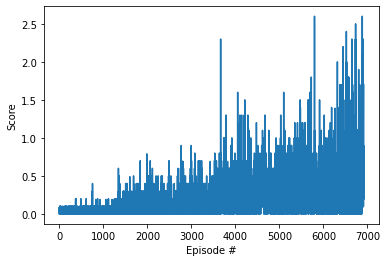

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
env.close()